**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchsummary import summary
from torch.utils.data import Dataset
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import Dataset

%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        
        sample['image'] = self.transform(sample['image']).float()
        sample['mask'] = self.transform(sample['mask']).float()

        return sample

In [3]:
X_train = get_paths("./data/train/images")
y_train = get_paths("./data/train/gt")

X_test = get_paths("./data/test/images")
y_test = get_paths("./data/test/gt")

transform = T.Compose([
    T.ToTensor(),
])

In [4]:
train_dataset = RoadDataset(X_train, y_train, transform)
test_dataset = RoadDataset(X_test, y_test, transform)

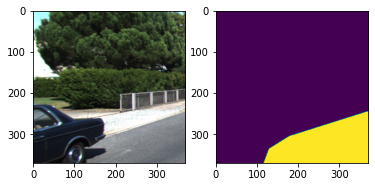

In [5]:
sample = train_dataset[4]
image = sample['image']
mask = sample['mask']

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [6]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

### Model U-Net

In [7]:
class ConvLayer(nn.Module):
    
    def __init__(self, input_channels, output_channels, padding='same',
                 kernel_size=(3, 3), stride=1, dilation=1, use_dropout=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                               out_channels=output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               dilation=dilation,
                               padding=padding)
        self.conv2 = nn.Conv2d(in_channels=output_channels, 
                               out_channels=output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               dilation=dilation,
                               padding=padding
                              )
        self.dropout2d = nn.Dropout2d(0.2)
        
        self.use_dropout = use_dropout
        
        self.batchnorm1 = nn.BatchNorm2d(num_features=output_channels)
        self.batchnorm2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        
        if self.use_dropout:
            x = self.dropout2d(x)
        
        return x

In [8]:
class DownScaller(nn.Module):
    
    def __init__(self, input_channels, output_channels, padding='same',
                 kernel_size=(3, 3), stride=1, dilation=1, use_dropout=False):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size = (2, 2))
        self.conv_layer = ConvLayer(input_channels, output_channels, padding, kernel_size,
                                    stride, dilation, use_dropout)
    
    def forward(self, input):
        x = self.maxpool(input)
        x = self.conv_layer(x)

        return x

In [9]:
class UpScaller(nn.Module):
    
    def __init__(self, input_channels, output_channels,
               kernel_size=(2, 2), stride=2, dilation=1, use_dropout=False):
        super().__init__()
        self.conv_layer = ConvLayer(input_channels, output_channels,
                                    kernel_size=(3, 3), stride=1, dilation=1, use_dropout=use_dropout)
        self.conv_transposed = nn.ConvTranspose2d(output_channels, output_channels // 2,
                                          kernel_size=kernel_size, stride=stride)
    
    
    def forward(self, input):
        x = self.conv_layer(input)
        x = self.conv_transposed(x)
        
        return x
        

In [10]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.pad = nn.ZeroPad2d(7)
        
        self.input_channel = 3
        self.output_channel = 48
        self.n_classes = 1
        
        # Input
        self.conv1 = ConvLayer(self.input_channel, self.output_channel)
        
        # Downscalling
        self.down1 = DownScaller(self.output_channel, self.output_channel * 2)
        self.down2 = DownScaller(self.output_channel * 2, self.output_channel * 4)
        self.down3 = DownScaller(self.output_channel * 4, self.output_channel * 8, use_dropout=True)
        
        # Bridge
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))   
        self.up1 = UpScaller(self.output_channel * 8, self.output_channel * 16)
        
        # Upscalling
        self.up2 = UpScaller(self.output_channel * 16, self.output_channel * 8, use_dropout=True)
        self.up3 = UpScaller(self.output_channel * 8, self.output_channel * 4)
        self.up4 = UpScaller(self.output_channel * 4, self.output_channel * 2)
        
        # Output
        self.conv2 = ConvLayer(self.output_channel * 2, self.output_channel)
        self.conv3 = nn.Conv2d(self.output_channel, self.n_classes, 
                               kernel_size=(3, 3), stride=1, dilation=1, padding='same')
        
    
    def forward(self, input):
        
        input = self.pad(input)
        
        x_1 = self.conv1(input)
        
        x_2 = self.down1(x_1)
        x_3 = self.down2(x_2)
        x_4 = self.down3(x_3)
        
        x_5 = self.maxpool(x_4)
        x_6 = self.up1(x_5)
        
        x_4_skip = self.center_crop(x_4, x_6)
        x_7 = self.up2(x_4_skip)
        
        x_3_skip = self.center_crop(x_3, x_7)
        x_8 = self.up3(x_3_skip)
        
        x_2_skip = self.center_crop(x_2, x_8)
        x_9 = self.up4(x_2_skip)
        
        x_1_skip = self.center_crop(x_1, x_9)
        x_10 = self.conv2(x_1_skip)
        
        output = self.conv3(x_10)
        
        return output
    
    def center_crop(self, source_tensor, target_tensor):
        (_, _, h, w) = target_tensor.shape
        crop = T.CenterCrop((h, w))(source_tensor)
        crop_concat = torch.cat([crop, target_tensor], dim=1)
        
        return crop_concat
        

In [11]:
# CHECK
unet = UNet()
a = torch.rand([4, 3, 572, 572])
out = unet(a)

print(out.shape)

torch.Size([4, 1, 576, 576])


### Train U-Net

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)
summary(model, input_size=train_dataset[0]['image'].shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 384, 384]               0
            Conv2d-2         [-1, 48, 384, 384]           1,344
              ReLU-3         [-1, 48, 384, 384]               0
       BatchNorm2d-4         [-1, 48, 384, 384]              96
            Conv2d-5         [-1, 48, 384, 384]          20,784
              ReLU-6         [-1, 48, 384, 384]               0
       BatchNorm2d-7         [-1, 48, 384, 384]              96
         ConvLayer-8         [-1, 48, 384, 384]               0
         MaxPool2d-9         [-1, 48, 192, 192]               0
           Conv2d-10         [-1, 96, 192, 192]          41,568
             ReLU-11         [-1, 96, 192, 192]               0
      BatchNorm2d-12         [-1, 96, 192, 192]             192
           Conv2d-13         [-1, 96, 192, 192]          83,040
             ReLU-14         [-1, 96, 1

In [21]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / (union + 1e-10)


def calc_dice_loss(pred, target, alpha = 1.):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    dice = 1 - (2 * intersection + alpha) / (pred.sum() + target.sum() + alpha) 
    
    return dice


def calc_loss(pred, target):
#     weights = torch.eye(target.shape[0]) * 0.5 + 1
    
    bce_loss = F.binary_cross_entropy_with_logits(pred, target, 
#                                                   weight=weights.to(device)
                                                 )
    dice_loss = calc_dice_loss(pred, target)
    
    loss = bce_loss + dice_loss
    
    return loss

In [22]:
def train_model(model, data_loader, optimizer):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(data_loader, 1):
        x_batch, y_batch = batch['image'].to(device), batch['mask'].to(device)
        y_batch = F.pad(y_batch, (7, 7, 7, 7))
        
        optimizer.zero_grad()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        loss.backward()
           
        optimizer.step()
        
        loss_history.append(loss.item())
        iou_history.append(calc_iou(output.cpu().detach().numpy(), 
                                    y_batch.cpu().detach().numpy()))
#         if i % 50 == 0:
#             print(loss_history[-1], iou_history[-1])
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}')
    
    return model

In [23]:
def eval_model(model, data_loader):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(data_loader, 1):
        x_batch, y_batch = batch['image'].to(device), batch['mask'].to(device)
        y_batch = F.pad(y_batch, (7, 7, 7, 7))
        
        with torch.no_grad():
            output = model(x_batch)
            loss = calc_loss(output, y_batch)
        
        loss_history.append(loss.item())
        iou_history.append(calc_iou(output.cpu().detach().numpy(), 
                                    y_batch.cpu().detach().numpy()))
        
#         if i % 50 == 0:
#             print(loss_history[-1], iou_history[-1])
    
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}\n')

In [24]:
BATCH_SIZE = 1
EPOCHS = 20

In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=False, batch_size=BATCH_SIZE,
                                           num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, 
                                          num_workers=12)

In [26]:
torch.cuda.empty_cache()

model = UNet().to(device)

optimizer = torch.optim.AdamW(model.parameters())
for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
    
    print('TRAIN')
    model.train() 
    model = train_model(model, train_loader, optimizer)
    print('VALID')
    model.eval()
    eval_model(model, test_loader)
    
    

EPOCH:   0%|          | 0/20 [00:00<?, ?it/s]

-------------------------------------------------- Epoch 1 / 20 --------------------------------------------------
TRAIN
Loss: -7.969 ± 135.353            IoU: 0.205  ± 0.242
VALID
Loss: 10.820 ± 66.798            IoU: 0.035  ± 0.050

-------------------------------------------------- Epoch 2 / 20 --------------------------------------------------
TRAIN
Loss: -1.316 ± 5.600            IoU: 0.029  ± 0.034
VALID
Loss: 7.027 ± 13.073            IoU: 0.042  ± 0.062

-------------------------------------------------- Epoch 3 / 20 --------------------------------------------------
TRAIN
Loss: -3.296 ± 6.954            IoU: 0.034  ± 0.038
VALID
Loss: 15.331 ± 110.366            IoU: 0.075  ± 0.087

-------------------------------------------------- Epoch 4 / 20 --------------------------------------------------
TRAIN


KeyboardInterrupt: 

In [19]:
image = train_dataset[0]['image'].to(device)

pred_mask = model(image[None, :, :, :])
pred_mask = T.CenterCrop(image.shape[1:])(pred_mask)

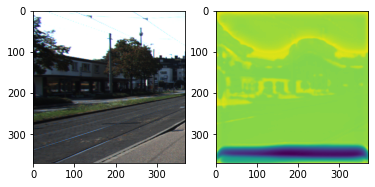

In [20]:
plt.subplot(1, 2, 1)
plt.imshow(image.cpu().permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(pred_mask.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())